We want the following
* images where the stimuli are now pairs of images from the original set
* The option images will always consist of one where the stimuli are the same and one where they are different (according to category)
* The 'test image' will have the same relationship between the categories as one of the option images but never with the same categories
* we want the train dataset to have equal number of match and non-match trials
* we want a count of how often each category is used in the train dataset

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')

In [4]:
set_A_ims = np.load(os.path.join(data_dir, 'set_A.npy'))
set_B_ims = np.load(os.path.join(data_dir, 'set_B.npy'))
set_C_ims = np.load(os.path.join(data_dir, 'set_C.npy'))
set_A_labs = np.load(os.path.join(data_dir, 'set_A_labs.npy'))
set_B_labs = np.load(os.path.join(data_dir, 'set_B_labs.npy'))
set_C_labs = np.load(os.path.join(data_dir, 'set_C_labs.npy'))

In [5]:
## create an rng object for reproducibility
rng = np.random.default_rng(seed=32)

In [30]:
def merge_images(images, idx1, idx2):
    """Helper function to merge two images horizontally"""
    img1 = images[idx1]
    img2 = images[idx2]
    return np.hstack((img1, img2))


In [31]:
def create_model_training_dataset(images, 
                                  labels, 
                                  n_trials=10000, 
                                  train_ratio=0.9,
                                  rng=rng,
                                  same_type='category'):
    # """
    # Create a dataset for training a model to perform a same/different task.
    # images: list of images (numpy arrays)
    # labels: list of labels corresponding to each image
    # n_trials: number of trials to generate
    # train_ratio: proportion of trials to use for training
    # rng: random number generator object for reproducibility
    # same_type: 'category' or 'exact'
    # """
    images = np.array(images) / 255.0  # Normalize to [0,1]
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    # Initialize tracking
    # category_pairs = []
    # trial_difficulties = []
    trials = {
        'test_images': [],
        'option_1_images': [],
        'option_2_images': [],
        'correct_options': [],
        'metadata': []
    }
    
    # Ensure balanced same/different trials
    n_same = n_trials // 2
    n_diff = n_trials - n_same
    
    for is_same in [True, False]:
        n_current = n_same if is_same else n_diff
        
        for _ in range(n_current):
            # Select test categories
            test_cat1 = rng.choice(unique_labels)
            test_cat2 = test_cat1 if is_same else rng.choice(unique_labels[unique_labels != test_cat1])
            
            # Select test images
            if is_same == True:
                test_idx1 = rng.choice(np.where(labels == test_cat1)[0])
                test_idx2 = test_idx1 if same_type == 'exact' else rng.choice(np.where(labels == test_cat2)[0])
                test_merged = merge_images(images, test_idx1, test_idx2)
            elif is_same == False:
                test_idx1 = rng.choice(np.where(labels == test_cat1)[0])
                test_idx2 = rng.choice(np.where(labels == test_cat2)[0])
                test_merged = merge_images(images, test_idx1, test_idx2)
                
            # Create options (randomize order)
            remaining_cats = unique_labels[~np.isin(unique_labels, [test_cat1])]
            
            opt_cats = rng.choice(remaining_cats, size=3, replace=False)
            
            # Create same-category option
            if same_type == 'category':
                same_idx1, same_idx2 = rng.choice(np.where(labels == opt_cats[0])[0], size=2, replace=False)
                same_merged = merge_images(images, same_idx1, same_idx2)
            elif same_type == 'exact':
                # Get array of indices and select one - ensure it's an array for consistency
                same_indices = np.where(labels == opt_cats[0])[0]
                same_idx1 = rng.choice(same_indices, size=1)[0]  # Get scalar value
                same_idx2 = same_idx1  # Use same scalar value
                same_merged = merge_images(images, same_idx1, same_idx2)
            # elif same_type == 'exact':
            #     same_idx1 = rng.choice(np.where(labels == opt_cats[0])[0], size=1, replace=False)
            #     same_idx2 = same_idx1
            #     same_merged = merge_images(images, same_idx1, same_idx2)
            
            # Create different-category option
            if same_type == 'category':
                diff_idx1 = rng.choice(np.where(labels == opt_cats[1])[0])
                diff_idx2 = rng.choice(np.where(labels == opt_cats[2])[0])
                diff_merged = merge_images(images, diff_idx1, diff_idx2)
            elif same_type == 'exact':
                # Get array of indices and select one - ensure it's an array for consistency
                diff_indices1 = np.where(labels == opt_cats[1])[0]
                diff_indices2 = np.where(labels == opt_cats[2])[0]
                diff_idx1 = rng.choice(diff_indices1, size=1)[0]
                diff_idx2 = rng.choice(diff_indices2, size=1)[0]
                diff_merged = merge_images(images, diff_idx1, diff_idx2)
                
            # Randomize option order
            if rng.random() > 0.5:
                option_1, option_2 = same_merged, diff_merged
                correct_option = 0 if is_same else 1
                opt_1_cats = (opt_cats[0], opt_cats[0])
                opt_2_cats = (opt_cats[1], opt_cats[2])
            else:
                option_1, option_2 = diff_merged, same_merged
                correct_option = 1 if is_same else 0
                opt_1_cats = (opt_cats[1], opt_cats[2])
                opt_2_cats = (opt_cats[0], opt_cats[0])
            
            # Store trial data
            trials['test_images'].append(test_merged)
            trials['option_1_images'].append(option_1)
            trials['option_2_images'].append(option_2)
            trials['correct_options'].append(correct_option)
            trials['metadata'].append({
                'test_categories': (test_cat1, test_cat2),
                'opt_1_categories': opt_1_cats,
                'opt_2_categories': opt_2_cats,
                'is_same': is_same,
                'trial_type': 'same' if is_same else 'different'
            })
    
    # Before converting to numpy arrays, get shuffle indices
    shuffle_idx = rng.permutation(len(trials['test_images']))
    
    # Apply shuffle to all trial data
    for key in trials.keys():
        trials[key] = [trials[key][i] for i in shuffle_idx]

    # Convert to numpy arrays
    
    for key in ['test_images', 'option_1_images', 'option_2_images', 'correct_options']:
        trials[key] = np.stack(trials[key])
    
    # Split train/test
    n_train = int(n_trials * train_ratio)
    train_data = {k: v[:n_train] for k, v in trials.items()}
    test_data = {k: v[n_train:] for k, v in trials.items()}
    
    return {
        'train': train_data,
        'test': test_data,
        'category_stats': pd.Series([m['test_categories'] for m in trials['metadata']]).value_counts()
    }

In [32]:
def create_overlapping_dfs(df, size_per_df=3000, rng=rng):
    """
    Creates three dataframes with specified overlap constraints
    """
    # Calculate required indices
    all_indices = np.arange(len(df))
    
    # Create df_a
    a_indices = rng.choice(all_indices, size=size_per_df, replace=False)
    df_a = df.iloc[a_indices].reset_index(drop=True)
    
    # Create df_b with 50% overlap with df_a
    overlap_ab_size = size_per_df // 2
    overlap_ab_indices = rng.choice(a_indices, size=overlap_ab_size, replace=False)
    remaining_indices = np.setdiff1d(all_indices, a_indices)
    unique_b_indices = rng.choice(remaining_indices, size=size_per_df-overlap_ab_size, replace=False)
    b_indices = np.concatenate([overlap_ab_indices, unique_b_indices])
    df_b = df.iloc[b_indices].reset_index(drop=True)
    
    # Create df_c with no overlap with df_a and 33.33% overlap with df_b
    overlap_bc_size = size_per_df // 3
    available_from_b = np.setdiff1d(b_indices, a_indices)  # Only use b indices that don't overlap with a
    overlap_bc_indices = rng.choice(available_from_b, size=overlap_bc_size, replace=False)
    remaining_for_c = np.setdiff1d(all_indices, np.concatenate([a_indices, b_indices]))
    unique_c_indices = rng.choice(remaining_for_c, size=size_per_df-overlap_bc_size, replace=False)
    c_indices = np.concatenate([overlap_bc_indices, unique_c_indices])
    df_c = df.iloc[c_indices].reset_index(drop=True)
    
    # Verify overlaps
    overlap_stats = {
        'ab_overlap': len(np.intersect1d(a_indices, b_indices)) / size_per_df,
        'ac_overlap': len(np.intersect1d(a_indices, c_indices)) / size_per_df,
        'bc_overlap': len(np.intersect1d(b_indices, c_indices)) / size_per_df
    }
    
    return df_a, df_b, df_c, overlap_stats

In [33]:
def view_trial(dataset, trial_idx=0, split='train'):
    """
    Display a single trial from the dataset with all relevant information
    """
    data = dataset[split]
    
    # Create figure with 3 subplots horizontally
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Trial {trial_idx} ({split} set)', fontsize=14)
    
    # Plot images
    axes[0].imshow(data['test_images'][trial_idx])
    axes[0].set_title('Test Pair')
    axes[0].axis('off')
    
    axes[1].imshow(data['option_1_images'][trial_idx])
    axes[1].set_title('Option 1' + (' ✓' if data['correct_options'][trial_idx] == 0 else ''))
    axes[1].axis('off')
    
    axes[2].imshow(data['option_2_images'][trial_idx])
    axes[2].set_title('Option 2' + (' ✓' if data['correct_options'][trial_idx] == 1 else ''))
    axes[2].axis('off')
    
    # Add metadata as text
    metadata = data['metadata'][trial_idx]
    # plt.figtext(0.02, 0.02, f'Metadata: {metadata}', fontsize=10, wrap=True)
    print(f'Correct Option: {data["correct_options"][trial_idx]}')
    print(f"Metadata: {metadata}")
    
    plt.tight_layout()
    plt.show()
    plt.close()

def view_multiple_trials(dataset, start_idx=0, n_trials=5, split='train'):
    """
    Display multiple trials in sequence
    """
    for idx in range(start_idx, min(start_idx + n_trials, len(dataset[split]['test_images']))):
        print(f"\nViewing trial {idx}")
        view_trial(dataset, idx, split)

### generate trials for category level match

In [34]:
all_trials = create_model_training_dataset(set_A_ims, set_A_labs)
training_trials = all_trials['train']
test_trials = all_trials['test']

In [35]:
trial_data = []
for i in range(len(training_trials['test_images'])):
    trial_data.append({
        'trial_index': i,
        'test_image': training_trials['test_images'][i],
        'option_1_image': training_trials['option_1_images'][i],
        'option_2_image': training_trials['option_2_images'][i],
        'correct_option': training_trials['correct_options'][i],
        'test_categories': training_trials['metadata'][i]['test_categories'],
        'option_1_categories': training_trials['metadata'][i]['opt_1_categories'],
        'option_2_categories': training_trials['metadata'][i]['opt_2_categories'],
        'trial_type': training_trials['metadata'][i]['trial_type']
    })
train_df = pd.DataFrame(trial_data)

trial_data = []
for i in range(len(test_trials['test_images'])):
    trial_data.append({
        'trial_index': i,
        'test_image': test_trials['test_images'][i],
        'option_1_image': test_trials['option_1_images'][i],
        'option_2_image': test_trials['option_2_images'][i],
        'correct_option': test_trials['correct_options'][i],
        'test_categories': test_trials['metadata'][i]['test_categories'],
        'option_1_categories': test_trials['metadata'][i]['opt_1_categories'],
        'option_2_categories': test_trials['metadata'][i]['opt_2_categories'],
        'trial_type': test_trials['metadata'][i]['trial_type']
    })
test_df = pd.DataFrame(trial_data)



In [36]:
train_df_a, train_df_b, train_df_c, overlap_stats = create_overlapping_dfs(train_df)

In [37]:
train_df_a.to_csv(os.path.join(data_dir, 'same_diff_train_df_a.csv'), index=False)
train_df_b.to_csv(os.path.join(data_dir, 'same_diff_train_df_b.csv'), index=False)
train_df_c.to_csv(os.path.join(data_dir, 'same_diff_train_df_c.csv'), index=False)
test_df.to_csv(os.path.join(data_dir, 'same_diff_test_df.csv'), index=False)



Viewing trial 0
Correct Option: 0
Metadata: {'test_categories': (0, 3), 'opt_1_categories': (2, 1), 'opt_2_categories': (3, 3), 'is_same': False, 'trial_type': 'different'}


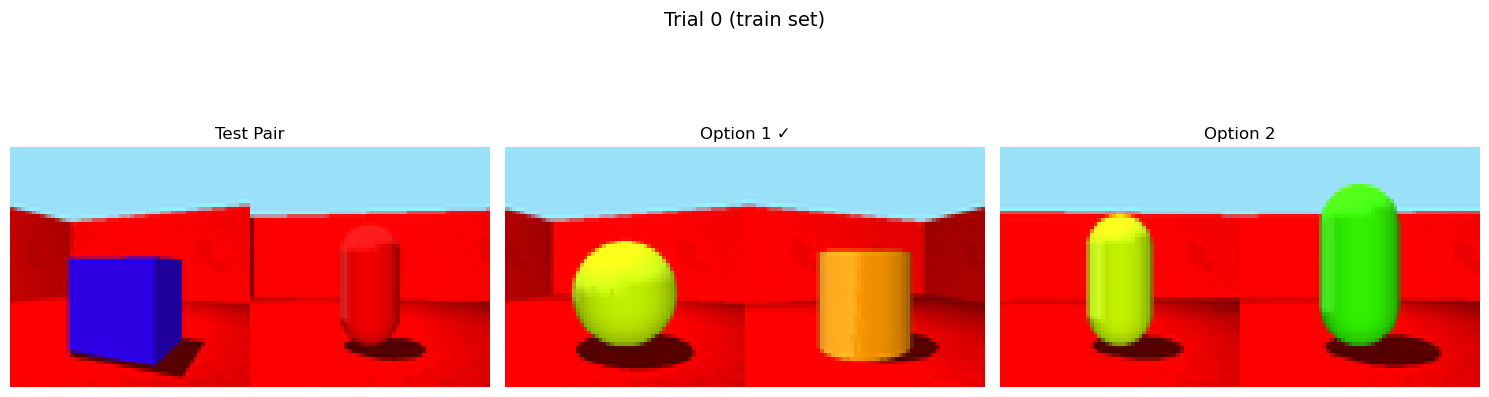


Viewing trial 1
Correct Option: 0
Metadata: {'test_categories': (3, 2), 'opt_1_categories': (2, 0), 'opt_2_categories': (1, 1), 'is_same': False, 'trial_type': 'different'}


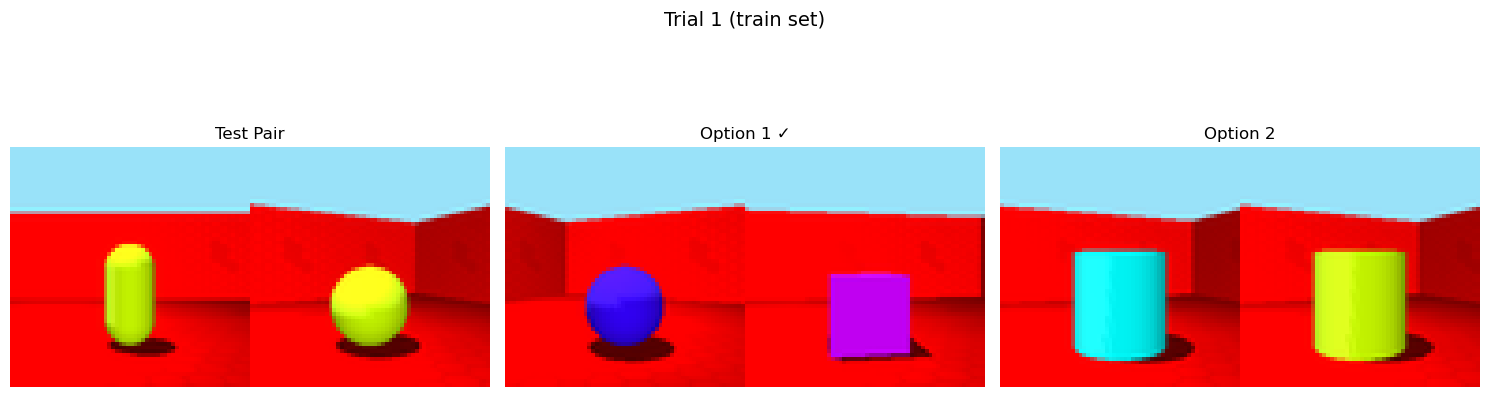


Viewing trial 2
Correct Option: 0
Metadata: {'test_categories': (0, 1), 'opt_1_categories': (2, 1), 'opt_2_categories': (3, 3), 'is_same': False, 'trial_type': 'different'}


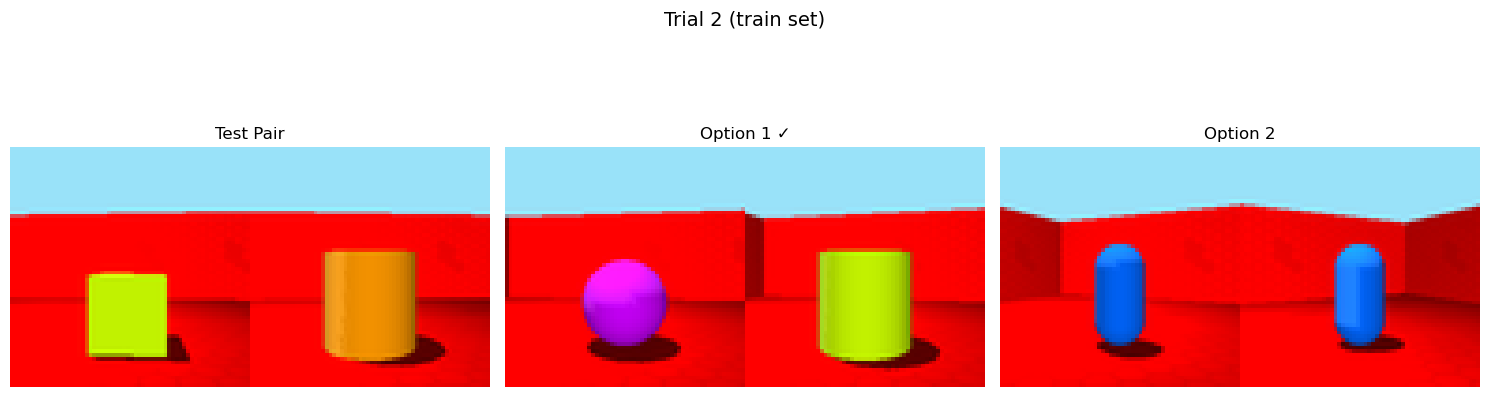


Viewing trial 3
Correct Option: 0
Metadata: {'test_categories': (1, 1), 'opt_1_categories': (3, 3), 'opt_2_categories': (0, 2), 'is_same': True, 'trial_type': 'same'}


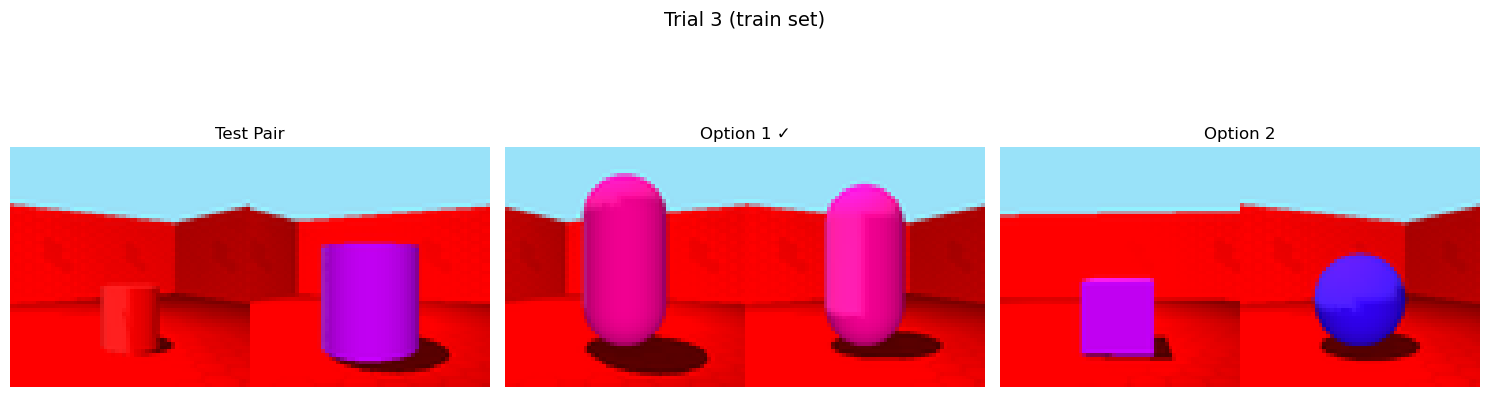


Viewing trial 4
Correct Option: 0
Metadata: {'test_categories': (2, 0), 'opt_1_categories': (3, 0), 'opt_2_categories': (1, 1), 'is_same': False, 'trial_type': 'different'}


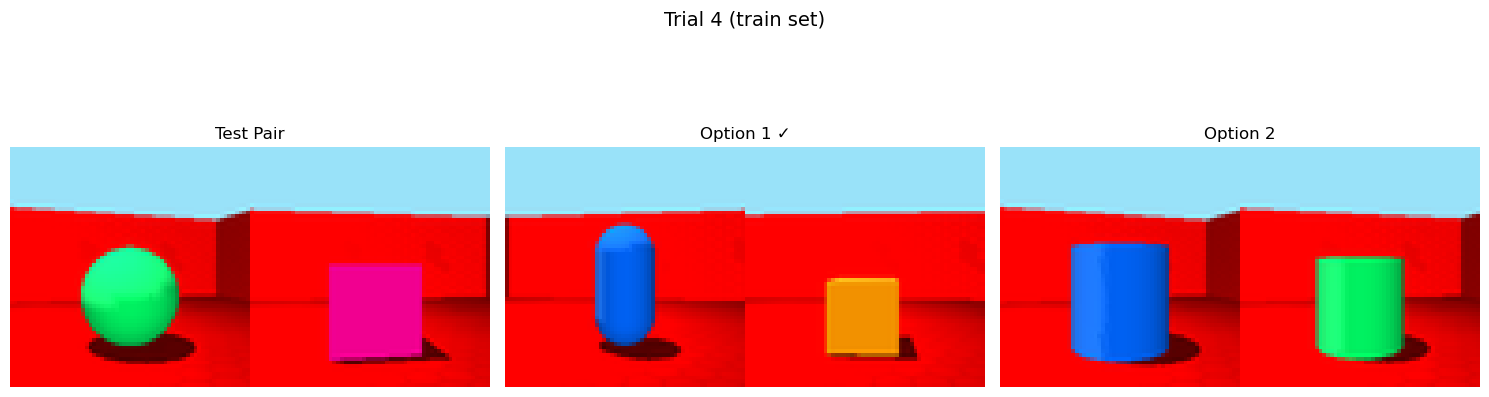


Viewing trial 5
Correct Option: 1
Metadata: {'test_categories': (1, 1), 'opt_1_categories': (3, 2), 'opt_2_categories': (0, 0), 'is_same': True, 'trial_type': 'same'}


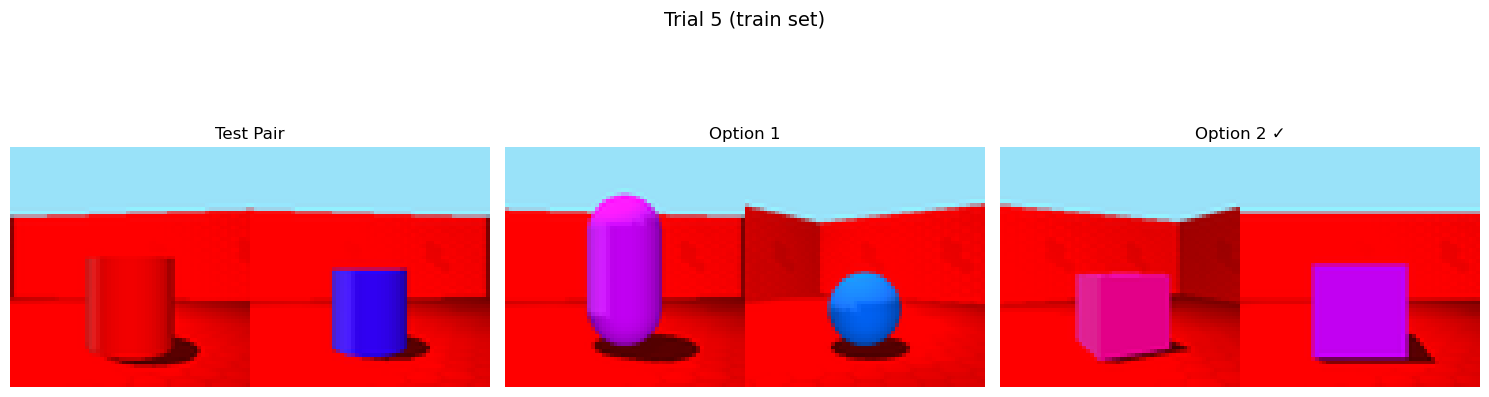


Viewing trial 6
Correct Option: 0
Metadata: {'test_categories': (3, 1), 'opt_1_categories': (2, 0), 'opt_2_categories': (1, 1), 'is_same': False, 'trial_type': 'different'}


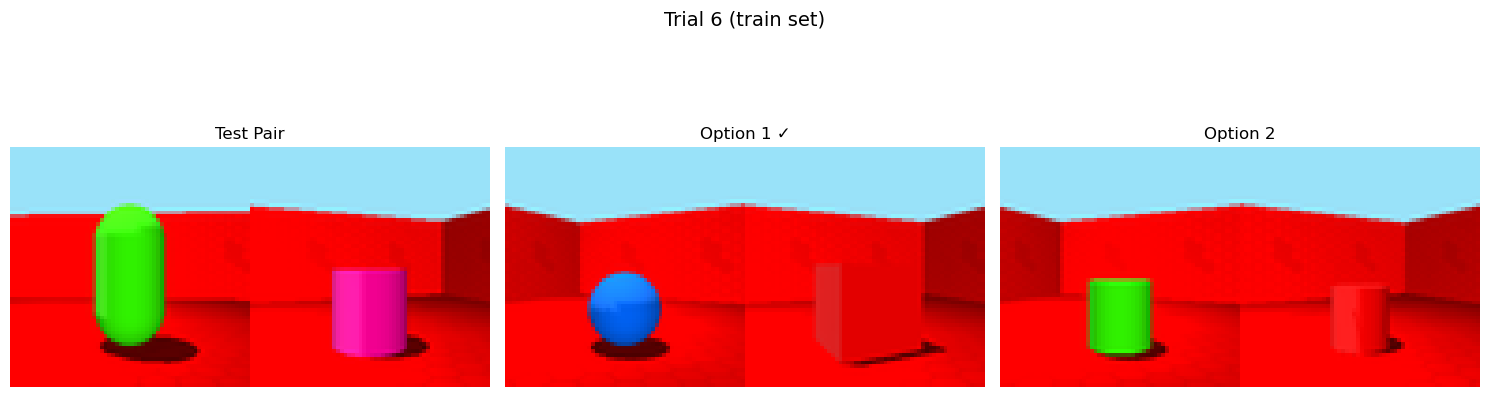


Viewing trial 7
Correct Option: 0
Metadata: {'test_categories': (2, 3), 'opt_1_categories': (1, 3), 'opt_2_categories': (0, 0), 'is_same': False, 'trial_type': 'different'}


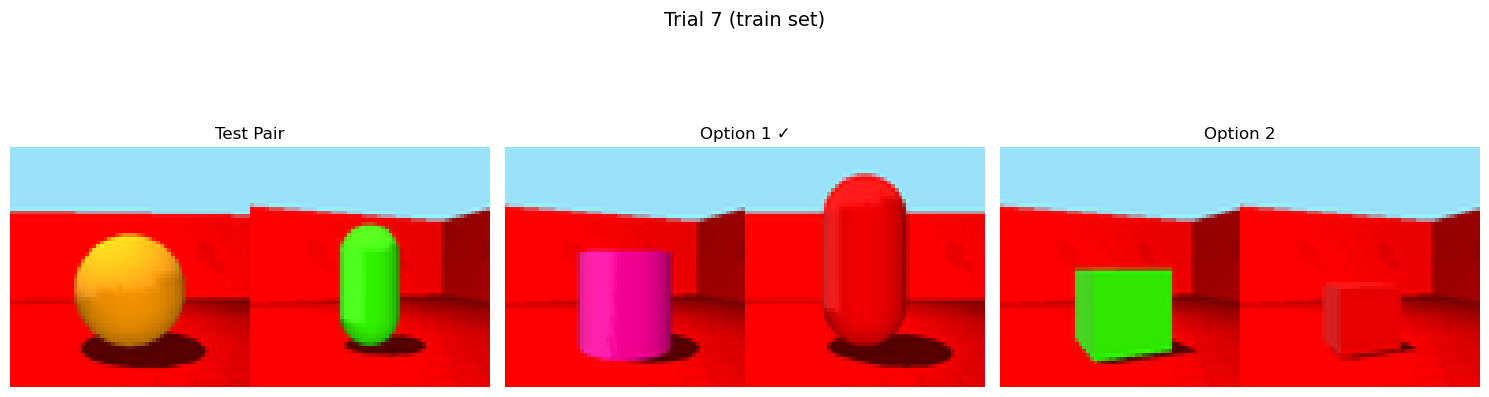


Viewing trial 8
Correct Option: 0
Metadata: {'test_categories': (0, 0), 'opt_1_categories': (2, 2), 'opt_2_categories': (1, 3), 'is_same': True, 'trial_type': 'same'}


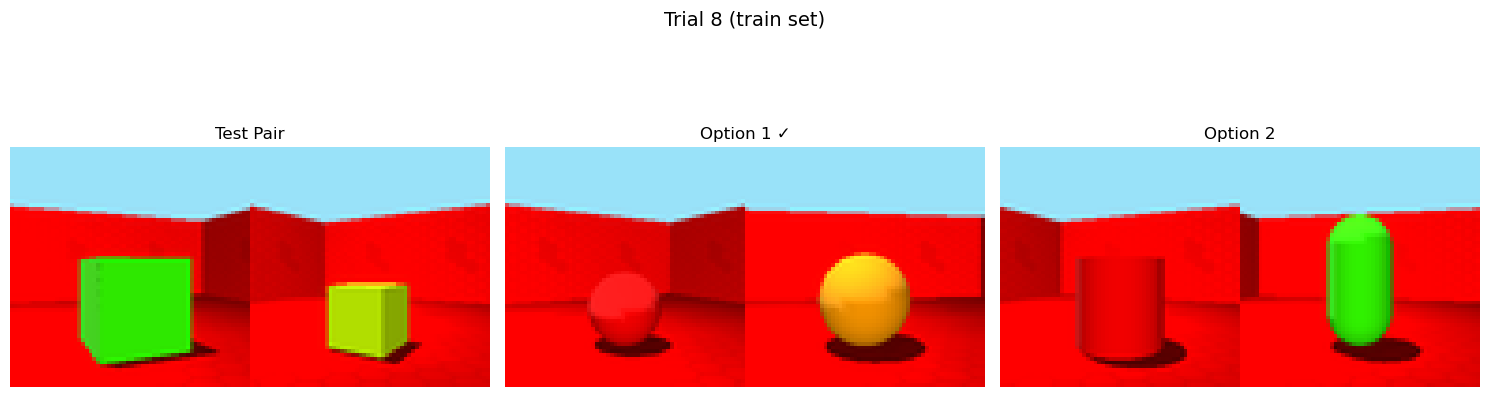


Viewing trial 9
Correct Option: 0
Metadata: {'test_categories': (3, 3), 'opt_1_categories': (0, 0), 'opt_2_categories': (1, 2), 'is_same': True, 'trial_type': 'same'}


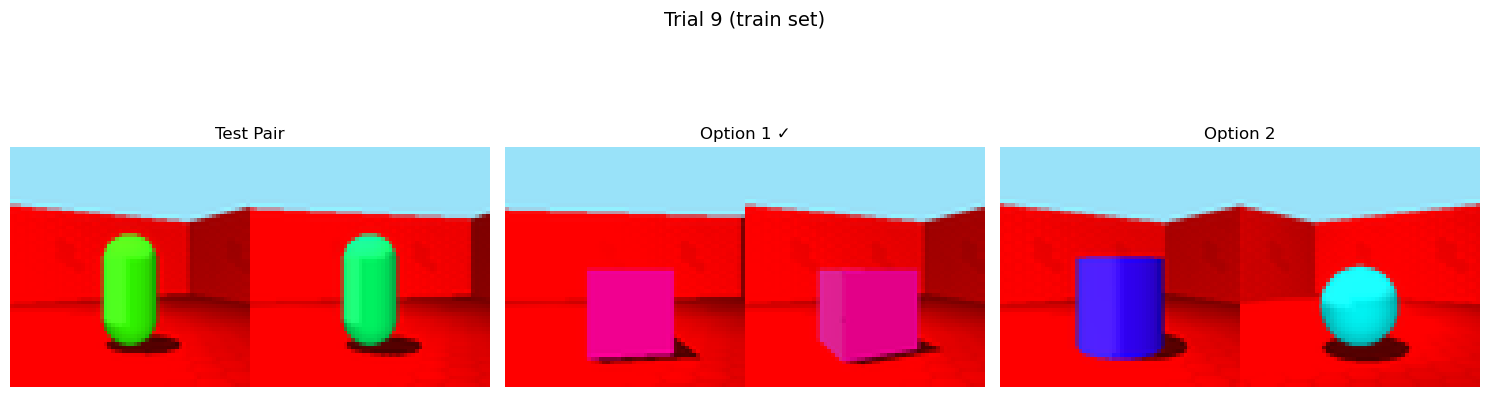

In [38]:
view_multiple_trials(all_trials, 0, 10, 'train')

### generate trials for exact match

In [39]:
all_trials = create_model_training_dataset(set_A_ims, set_A_labs, same_type='exact')
training_trials = all_trials['train']
test_trials = all_trials['test']

In [40]:
trial_data = []
for i in range(len(training_trials['test_images'])):
    trial_data.append({
        'trial_index': i,
        'test_image': training_trials['test_images'][i],
        'option_1_image': training_trials['option_1_images'][i],
        'option_2_image': training_trials['option_2_images'][i],
        'correct_option': training_trials['correct_options'][i],
        'test_categories': training_trials['metadata'][i]['test_categories'],
        'option_1_categories': training_trials['metadata'][i]['opt_1_categories'],
        'option_2_categories': training_trials['metadata'][i]['opt_2_categories'],
        'trial_type': training_trials['metadata'][i]['trial_type']
    })
train_df = pd.DataFrame(trial_data)

trial_data = []
for i in range(len(test_trials['test_images'])):
    trial_data.append({
        'trial_index': i,
        'test_image': test_trials['test_images'][i],
        'option_1_image': test_trials['option_1_images'][i],
        'option_2_image': test_trials['option_2_images'][i],
        'correct_option': test_trials['correct_options'][i],
        'test_categories': test_trials['metadata'][i]['test_categories'],
        'option_1_categories': test_trials['metadata'][i]['opt_1_categories'],
        'option_2_categories': test_trials['metadata'][i]['opt_2_categories'],
        'trial_type': test_trials['metadata'][i]['trial_type']
    })
test_df = pd.DataFrame(trial_data)



In [41]:
train_df_a, train_df_b, train_df_c, overlap_stats = create_overlapping_dfs(train_df)

In [42]:
train_df_a.to_csv(os.path.join(data_dir, 'same_diff_train_exact_match_df_a.csv'), index=False)
train_df_b.to_csv(os.path.join(data_dir, 'same_diff_train_exact_match_b.csv'), index=False)
train_df_c.to_csv(os.path.join(data_dir, 'same_diff_train_exact_match_c.csv'), index=False)
test_df.to_csv(os.path.join(data_dir, 'same_diff_train_exact_match_df.csv'), index=False)



Viewing trial 0
Correct Option: 1
Metadata: {'test_categories': (2, 0), 'opt_1_categories': (0, 0), 'opt_2_categories': (3, 1), 'is_same': False, 'trial_type': 'different'}


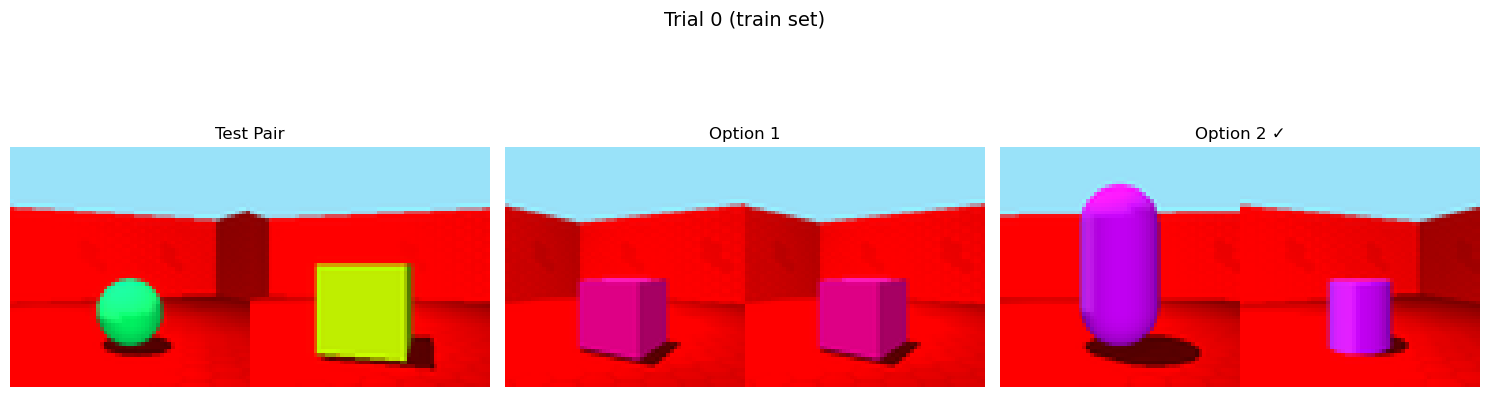


Viewing trial 1
Correct Option: 1
Metadata: {'test_categories': (1, 1), 'opt_1_categories': (2, 0), 'opt_2_categories': (3, 3), 'is_same': True, 'trial_type': 'same'}


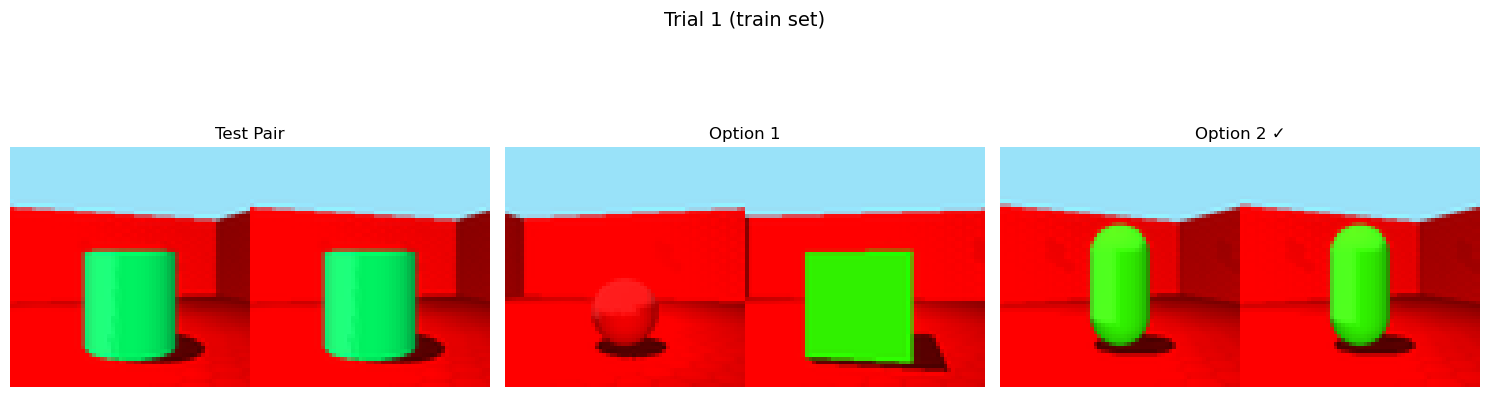


Viewing trial 2
Correct Option: 0
Metadata: {'test_categories': (2, 1), 'opt_1_categories': (1, 3), 'opt_2_categories': (0, 0), 'is_same': False, 'trial_type': 'different'}


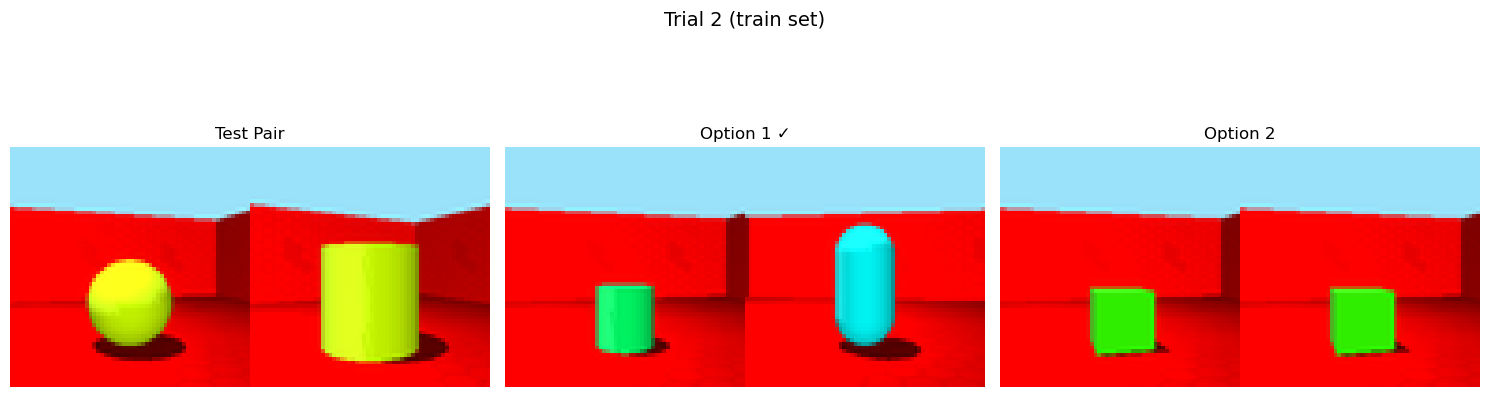


Viewing trial 3
Correct Option: 1
Metadata: {'test_categories': (1, 1), 'opt_1_categories': (3, 2), 'opt_2_categories': (0, 0), 'is_same': True, 'trial_type': 'same'}


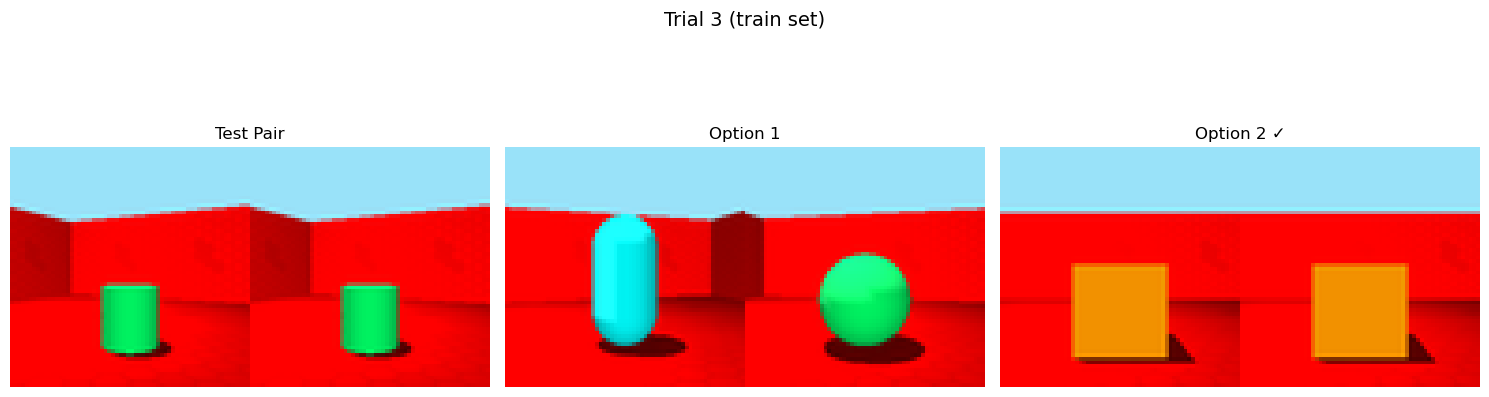


Viewing trial 4
Correct Option: 1
Metadata: {'test_categories': (2, 2), 'opt_1_categories': (0, 3), 'opt_2_categories': (1, 1), 'is_same': True, 'trial_type': 'same'}


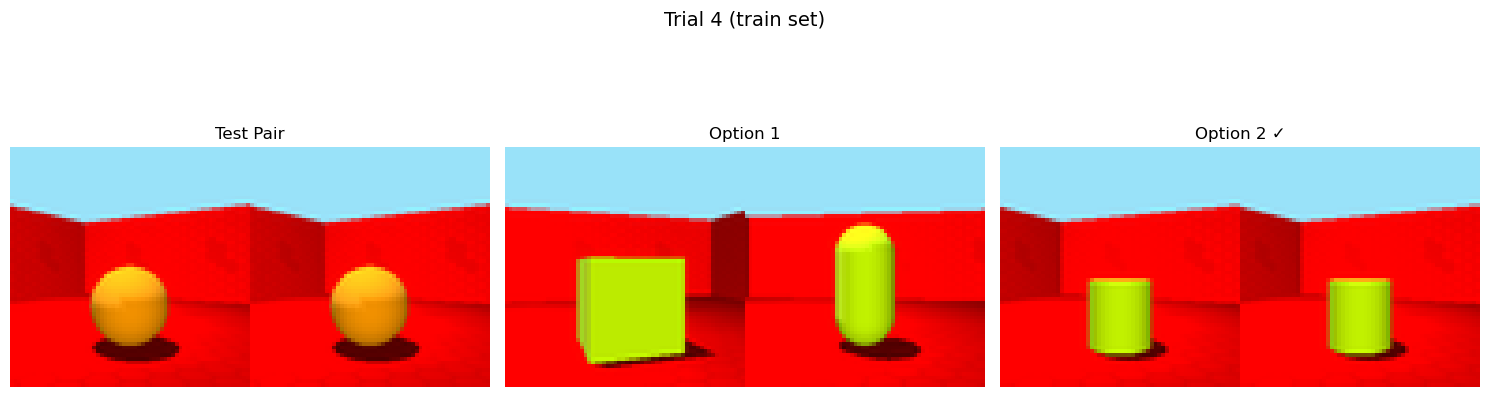


Viewing trial 5
Correct Option: 1
Metadata: {'test_categories': (2, 1), 'opt_1_categories': (0, 0), 'opt_2_categories': (1, 3), 'is_same': False, 'trial_type': 'different'}


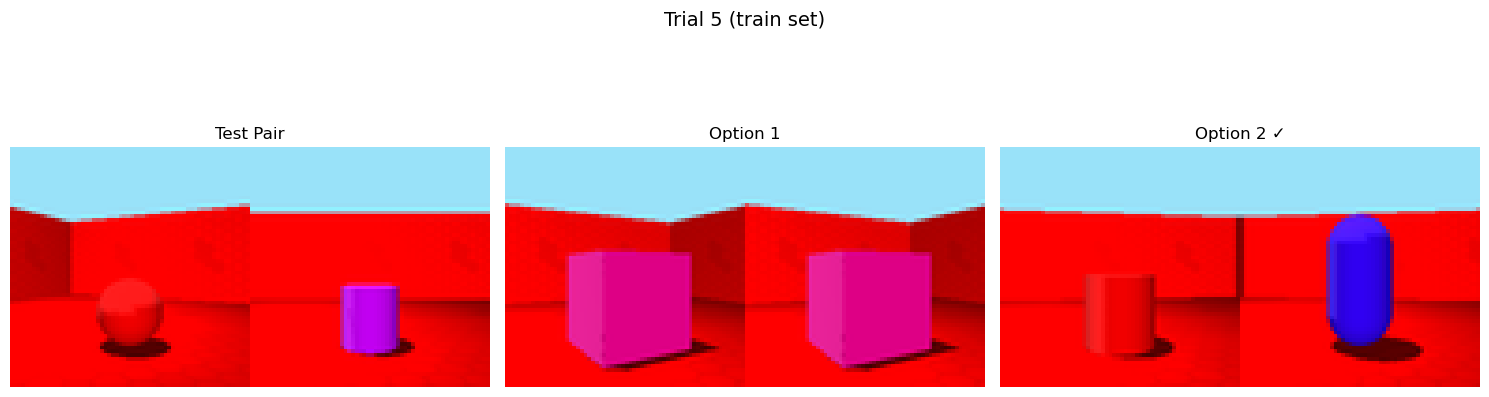


Viewing trial 6
Correct Option: 1
Metadata: {'test_categories': (2, 2), 'opt_1_categories': (3, 0), 'opt_2_categories': (1, 1), 'is_same': True, 'trial_type': 'same'}


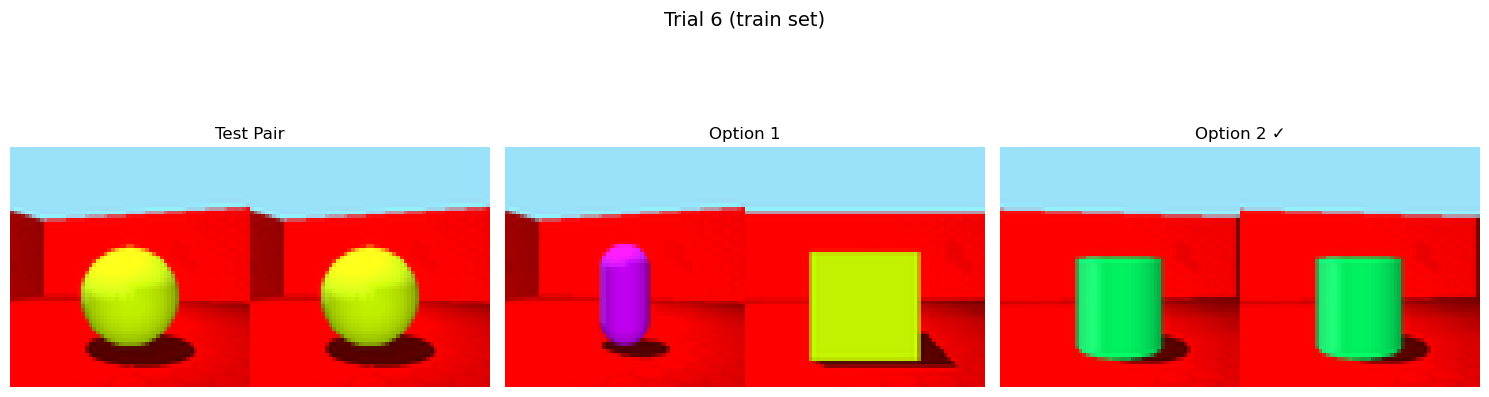


Viewing trial 7
Correct Option: 0
Metadata: {'test_categories': (3, 2), 'opt_1_categories': (0, 1), 'opt_2_categories': (2, 2), 'is_same': False, 'trial_type': 'different'}


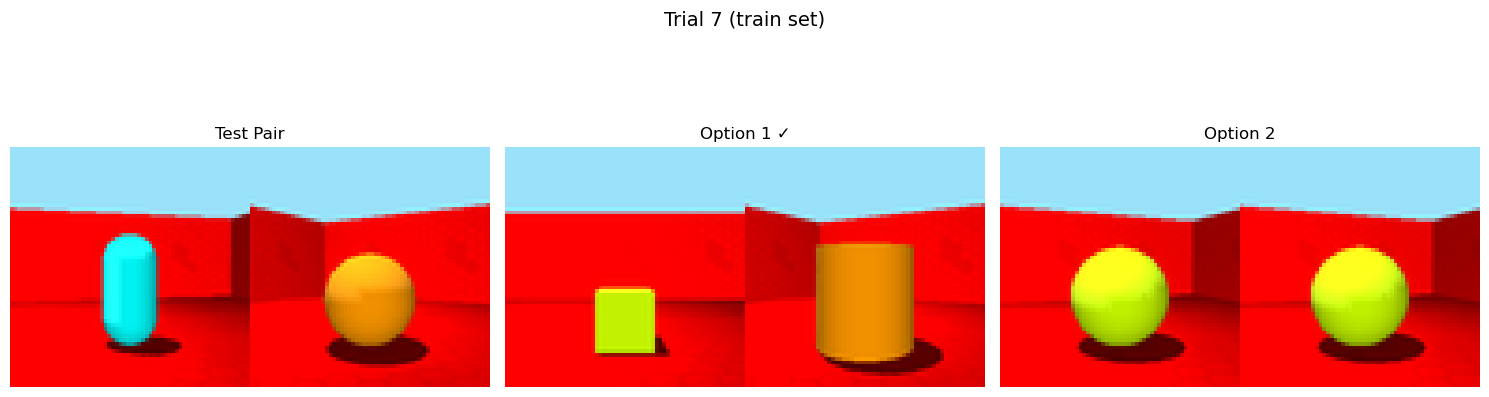


Viewing trial 8
Correct Option: 0
Metadata: {'test_categories': (3, 3), 'opt_1_categories': (2, 2), 'opt_2_categories': (1, 0), 'is_same': True, 'trial_type': 'same'}


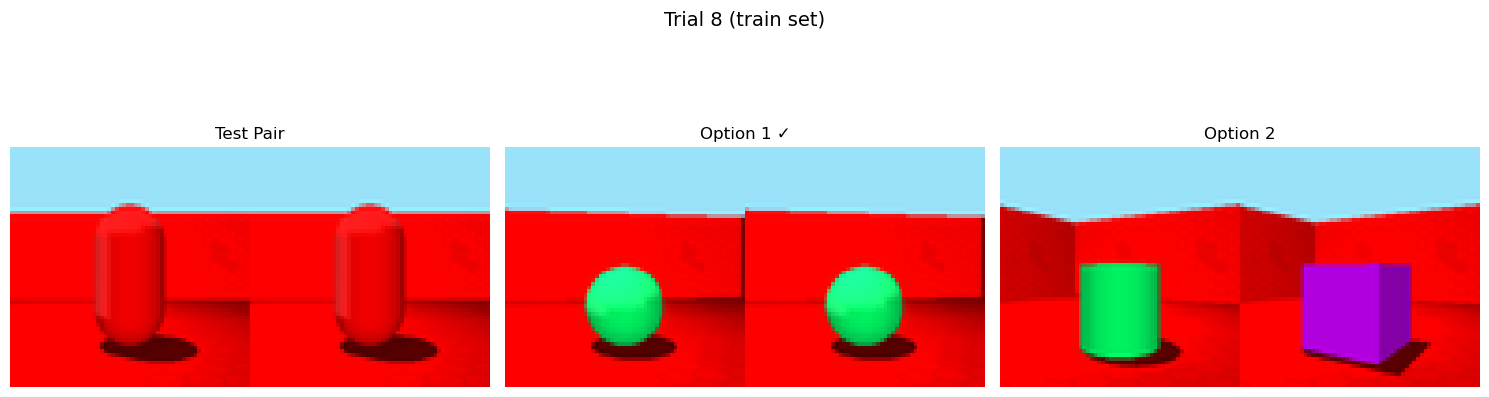


Viewing trial 9
Correct Option: 1
Metadata: {'test_categories': (0, 0), 'opt_1_categories': (2, 1), 'opt_2_categories': (3, 3), 'is_same': True, 'trial_type': 'same'}


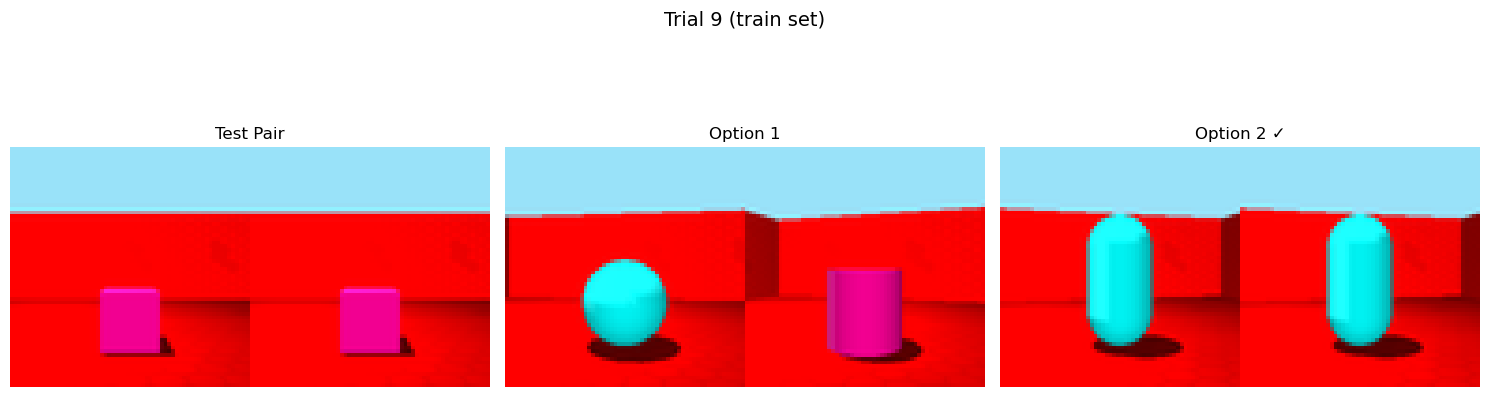

In [43]:
view_multiple_trials(all_trials, 0, 10, 'train')

In [6]:
a = pd.read_csv(os.path.join(data_dir, 'same_diff_train_exact_match_df_a.csv'))

In [7]:
a

,trial_index,test_image,option_1_image,option_2_image,correct_option,test_categories,option_1_categories,option_2_categories,trial_type
0,435,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,1,"(1, 2)","(3, 3)","(2, 0)",different
1,5118,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,0,"(1, 1)","(2, 2)","(3, 0)",same
2,315,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,0,"(3, 0)","(0, 2)","(1, 1)",different
3,2024,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,0,"(2, 2)","(1, 1)","(0, 3)",same
4,2168,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,1,"(2, 2)","(0, 3)","(1, 1)",same
...,...,...,...,...,...,...,...,...,...
2995,6834,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,1,"(3, 3)","(2, 0)","(1, 1)",same
2996,7940,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,1,"(3, 3)","(2, 1)","(0, 0)",same
2997,4300,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,0,"(3, 0)","(1, 2)","(0, 0)",different
2998,7451,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,[[[0.6 0.88627451 0.97647059]\n [0.6 ...,0,"(2, 0)","(3, 0)","(1, 1)",different


In [ ]:
train_df_a.to_csv(os.path.join(data_dir, 'same_diff_train_exact_match_df_a.csv'), index=False)